# Assignment 2 - DES simulation
#### Multiple Queues and Multiple Servers

For this assignment, we'll be using the following notation:
- $\lambda$ - the arrival rate into the system as a whole.
- $\mu$ - the capacity of each of $n$ equal servers.
- $\rho$ represents the system load. In a single server system, it will be: $\rho = \frac{\lambda}{\mu}$
- In a multi-server system (one queue with $n$ equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{n\mu}$.

Queuing theory tells us that for FIFO scheduling, the average waiting times are shorter for an $M/M/n$ queue and a system load $\rho$ and processor capacity $\mu$ than for a single $M/M/1$ queue with the same load characteristics (and thus an $n$-fold lower arrival rate). Of course, $\rho$ must be less than one, but the experiment only becomes interesting when $\rho$ is not much less than one.

1. Look up and/or derive this theoretical result, at least for $n = 2$. Describe how it is derived. Can you also give a non-mathematical explanation?
2. Write a DES program to verify this for $n = 1, n = 2$, and $n = 4$. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on $\rho$?
3. Also compare the result to that for an $M/M/1$ queue with shortest job first scheduling, where you always give priority to the smallest jobs.
4. Now experiment with different service rate distributions. On the one hand, try the $M/D/1$ and $M/D/n$ queues; on the other hand, try a long-tail distribution. For the latter, you may, for example, use a distribution where 75% of the jobs have an exponential distribution with an average service time of 1.0, and the remaining 25% have an exponential distribution with an average service time of 5.0 (an example of a hyperexponential distribution). Write your program using SimPy.



### 1. Proof
From Little's Law follows: $E(W) = \frac{E(L^q)}{\lambda}$


In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import simpy
import itertools

from scipy.stats import norm

In [68]:
class Bank:
    """
    A bank has a limited number of counters (``NUM_COUNTERS``) to serve customers in parallel.
    """

    def __init__(self, env, num_counters, service_rate):
        self.env = env
        self.counter = simpy.Resource(env, num_counters)
        self.service_rate = service_rate
        self.customers_served = 0
        self.waiting_times = []
    
    def serve(self, customer, waiting_time):
        """
        The customer is served for a certain amount of time.
        """
        self.customers_served += 1
        self.waiting_times.append(waiting_time)
        yield self.env.timeout(random.expovariate(self.service_rate))

def setup(env, bank, sim_time, arrival_rate, print_all=False):
    customer_count = itertools.count()

    # Create more cars while the simulation is running
    while env.now < sim_time:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, f'Customer {next(customer_count)}', bank, print_all=print_all))
    

def customer(env, name, bank, print_all=False):
    """Customer arrives, is served and leaves."""
    arrive = env.now

    if print_all:
        print('%7.4f %s: Here I am' % (arrive, name))

    with bank.counter.request() as req:
        yield req
        wait = env.now - arrive

        if print_all:
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

        yield env.process(bank.serve(name, wait))

        if print_all:
            print('%7.4f %s: Finished' % (env.now, name))

# Example usage:
RANDOM_SEED = 42
LAMBDA = 1/12 # Arrival rate
MU = 1/10 # Service rate
SIMULATION_TIME = 50
n = 1 # Number of counters

LOAD = LAMBDA/(MU * n) # Load of the system, should be < 1 for stable system

print(f"M/M/1 queue simulation with λ={LAMBDA}, μ={MU}, ρ = {LOAD}")
print(f"Simulation time: {SIMULATION_TIME}")

random.seed(RANDOM_SEED)
env = simpy.Environment()

bank = Bank(env, n, MU)

env.process(setup(env, bank, SIMULATION_TIME, LAMBDA, print_all=True))
env.run()

print(f"Customers served: {bank.customers_served}")
print(f"Average waiting time: {sum(bank.waiting_times)/len(bank.waiting_times)}")


M/M/1 queue simulation with λ=0.08333333333333333, μ=0.1, ρ = 0.8333333333333333
Simulation time: 50
12.2407 Customer 0: Here I am
12.2407 Customer 0: Waited  0.000
12.5447 Customer 1: Here I am
15.4570 Customer 0: Finished
15.4570 Customer 1: Waited  2.912
15.5757 Customer 2: Here I am
28.7929 Customer 1: Finished
28.7929 Customer 2: Waited 13.217
29.1258 Customer 3: Here I am
30.2172 Customer 4: Here I am
36.7938 Customer 5: Here I am
37.1568 Customer 6: Here I am
40.1174 Customer 7: Here I am
48.5644 Customer 8: Here I am
48.8871 Customer 9: Here I am
51.0658 Customer 2: Finished
51.0658 Customer 3: Waited 21.940
51.5474 Customer 10: Here I am
61.5607 Customer 3: Finished
61.5607 Customer 4: Waited 31.343
69.4340 Customer 4: Finished
69.4340 Customer 5: Waited 32.640
71.9242 Customer 5: Finished
71.9242 Customer 6: Waited 34.767
80.8223 Customer 6: Finished
80.8223 Customer 7: Waited 40.705
97.3997 Customer 7: Finished
97.3997 Customer 8: Waited 48.835
97.4649 Customer 8: Finished
9

In [89]:
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate
LOAD = 0.99 # Load factor

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

for n in [1, 2, 4]:
    avg_customers_served = []
    avg_waiting_times = []

    while True:
        LAMBDA = MU * LOAD * n

        env = simpy.Environment()
        bank = Bank(env, n, MU)

        env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
        env.run()

        avg_customers_served.append(bank.customers_served)
        avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

        # Only start checking after 100 repetitions
        if len(avg_waiting_times) < 100:
            continue

        # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
        S = np.std(avg_waiting_times, ddof=1)

        if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
            break

    # Print results
    print(f"M/M/{n} queue simulation with λ = {round(LAMBDA, decimals)}, μ = {round(MU, decimals)}, ρ = {round(LOAD, decimals)} ({len(avg_waiting_times)} repetitions to reach 95% confidence)")
    print(f"Customers served: {round(np.mean(avg_customers_served), decimals)}")
    print(f"Average waiting time: {round(np.mean(avg_waiting_times), decimals)} s\n")

M/M/1 queue simulation with λ = 0.0825, μ = 0.0833, ρ = 0.99 (628 repetitions to reach 95% confidence)
Customers served: 42.4506
Average waiting time: 50.4443 s

M/M/2 queue simulation with λ = 0.165, μ = 0.0833, ρ = 0.99 (270 repetitions to reach 95% confidence)
Customers served: 82.7889
Average waiting time: 32.3009 s

M/M/4 queue simulation with λ = 0.33, μ = 0.0833, ρ = 0.99 (156 repetitions to reach 95% confidence)
Customers served: 167.359
Average waiting time: 24.2087 s



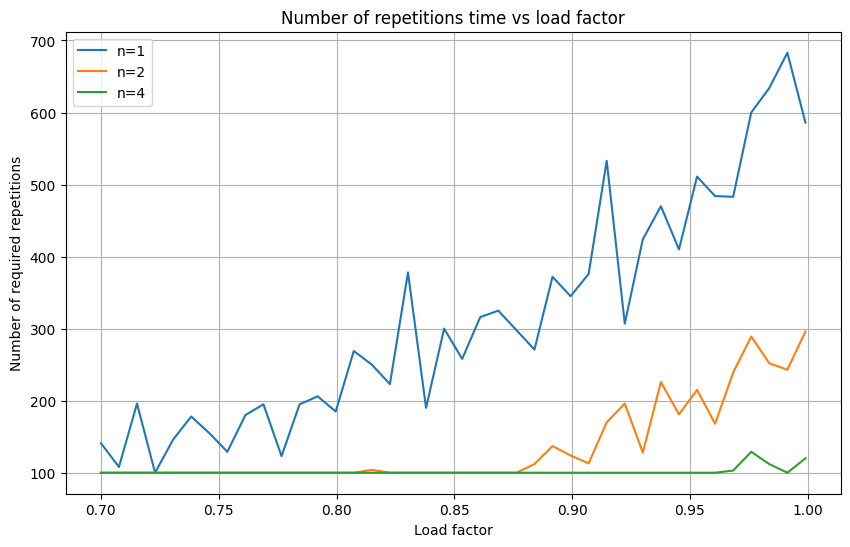

In [100]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for LOAD in np.linspace(0.7, 0.999, 40):
    for n in [1, 2, 4]:
        avg_customers_served = []
        avg_waiting_times = []
        
        while True:
            LAMBDA = MU * LOAD * n

            env = simpy.Environment()
            bank = Bank(env, n, MU)

            env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
            env.run()

            avg_customers_served.append(bank.customers_served)
            avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

            # Only start checking after 100 repetitions
            if len(avg_waiting_times) < 100:
                continue

            # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
            S = np.std(avg_waiting_times, ddof=1)

            if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                break
        
        results.loc[len(results) - 1] = {
            'n': n,
            'load': LOAD,
            'avg_customers_served': np.mean(avg_customers_served),
            'avg_waiting_time': np.mean(avg_waiting_times),
            'repetitions': len(avg_waiting_times)
        }

results_n1 = results[results['n'] == 1]
results_n2 = results[results['n'] == 2]
results_n4 = results[results['n'] == 4]

# Plot results
plt.figure(figsize=(10, 6))
plt.title("Number of repetitions time vs load factor")
plt.xlabel("Load factor")
plt.ylabel("Number of required repetitions")
plt.grid()
plt.plot(results_n1['load'], results_n1['repetitions'], label="n=1")
plt.plot(results_n2['load'], results_n2['repetitions'], label="n=2")
plt.plot(results_n4['load'], results_n4['repetitions'], label="n=4")
plt.legend()
plt.show()


In [99]:
results

,n,load,avg_customers_served,avg_waiting_time,repetitions
-1,1,0.700000,30.326241,20.239488,141
0,2,0.700000,59.840000,10.498237,100
1,4,0.700000,117.750000,3.689409,100
2,1,0.707667,30.425926,18.929886,108
3,2,0.707667,58.330000,9.131270,100
...,...,...,...,...,...
114,2,0.991333,83.283951,31.798043,243
115,4,0.991333,165.920000,21.414622,100
116,1,0.999000,42.544369,48.800595,586
117,2,0.999000,83.875000,33.521247,296
